In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import SGD, Adam
import matplotlib .pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.applications import InceptionV3, MobileNet

# Project-1

## 경로설정 및 데이터 가져오기

In [ ]:
root_dir = "/content"
data_root_dir = os.path.join(root_dir, "chest_x_ray")
train_root_dir = os.path.join(data_root_dir, "train")
test_root_dir = os.path.join(data_root_dir, "test")
val_root_dir = os.path.join(data_root_dir, "val")

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

shutil.copy(os.path.join("/content/drive/MyDrive", "Chest_Xray_Pneumonia.zip"), root_dir)

with zipfile.ZipFile(os.path.join(root_dir, "Chest_Xray_Pneumonia.zip")) as target_file:
  target_file.extractall(data_root_dir)

Mounted at /content/drive


## 정답 및 데이터 갯수 확인
- 전체 데이터를 train 폴더에 모은 후 이미지 전처리

In [ ]:
## 각 폴더 DATA갯수 확인
label_name_list = os.listdir(train_root_dir)

for label_name in label_name_list:
  print("train label : ", label_name, "/", len(os.listdir(os.path.join(train_root_dir, label_name))))

print("------------------------------------------------")

for label_name in label_name_list:
  print("test label : ", label_name, "/", len(os.listdir(os.path.join(test_root_dir, label_name))))

print("------------------------------------------------")

for label_name in label_name_list:
  print("val label : ", label_name, "/", len(os.listdir(os.path.join(val_root_dir, label_name))))

train label :  NORMAL / 1341
train label :  PNEUMONIA / 3875
------------------------------------------------
test label :  NORMAL / 234
test label :  PNEUMONIA / 390
------------------------------------------------
val label :  NORMAL / 8
val label :  PNEUMONIA / 8


In [ ]:
# test, val data => train data 이동
for label_name in label_name_list:
  src_test_root = os.path.join(test_root_dir, label_name)
  src_val_root = os.path.join(val_root_dir, label_name)
  dst_root = os.path.join(train_root_dir, label_name)

  test_file_name_list = os.listdir(src_test_root)
  val_file_name_list = os.listdir(src_val_root)

  for test_file_name in test_file_name_list:
    shutil.move(os.path.join(src_test_root, test_file_name),
                os.path.join(dst_root, test_file_name))

  for val_file_name in val_file_name_list:
    shutil.move(os.path.join(src_val_root, val_file_name),
                os.path.join(dst_root, val_file_name))

# 데이터 확인
label_name_list = os.listdir(train_root_dir)

for label_name in label_name_list:
  print("train label : ", label_name, "/", len(os.listdir(os.path.join(train_root_dir, label_name))))

print("------------------------------------------------")

for label_name in label_name_list:
  print("test label : ", label_name, "/", len(os.listdir(os.path.join(test_root_dir, label_name))))

print("------------------------------------------------")

for label_name in label_name_list:
  print("val label : ", label_name, "/", len(os.listdir(os.path.join(val_root_dir, label_name))))

train label :  NORMAL / 1583
train label :  PNEUMONIA / 4273
------------------------------------------------
test label :  NORMAL / 0
test label :  PNEUMONIA / 0
------------------------------------------------
val label :  NORMAL / 0
val label :  PNEUMONIA / 0


# 이미지 전처리

In [ ]:
# 이미지 전처리
img_list = []
label_list = []

dict_class = {"NORMAL" : 0, 'PNEUMONIA' : 1}

for label_name in label_name_list:
  img_file_list = glob.glob(os.path.join(train_root_dir, label_name) + "/*.*")

  for img_file in img_file_list:
    src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize = (224, 224))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    img_list.append(src_img)
    label_list.append(dict_class[label_name])

In [ ]:
# train / test 나누기
X_train, X_test, y_train, y_test = train_test_split(np.array(img_list),
                                                    np.array(label_list),
                                                    test_size = 0.2)

In [ ]:
print(X_train.shape, X_test.shape)

(4684, 224, 224, 3) (1172, 224, 224, 3)


In [ ]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# 정규화
X_train = X_train / 255.0
X_test = X_test / 255.0

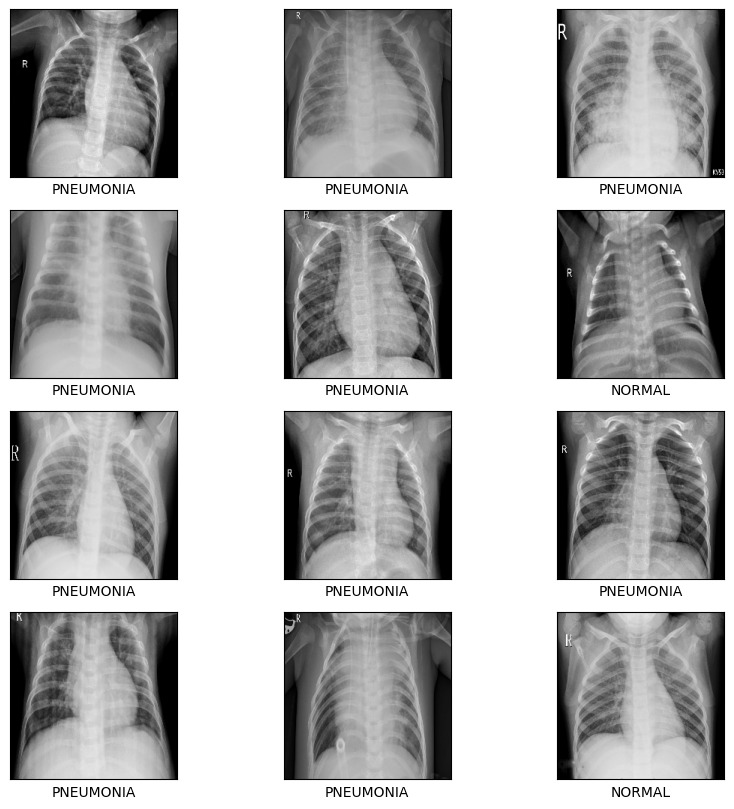

In [ ]:
# sample 이미지 출력
plt.figure(figsize = (10, 10))
class_dict = {0:"NORMAL", 1:'PNEUMONIA'}

for i in range(12):
  plt.subplot(4, 3, i+1)
  plt.imshow(X_train[i], cmap = "gray")
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(class_dict[y_train[i]])

# CNN 모델생성

# 1) 계층 비교

### (1) C-C-P-C-C-P-F-D-D
- filter : 64, 128
- hidden 2개 (node : 128)
- dropout 0.3
- 학습률 : 0.0001

In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(Conv2D(filters=128, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0001),
              metrics = "accuracy")
model.summary()

start_time = datetime.now()

result = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2)

end_time = datetime.now()
print("걸린시간 : ", end_time - start_time)
model.evaluate(X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 128)     147584    
                                                      

[0.24189896881580353, 0.9633105993270874]

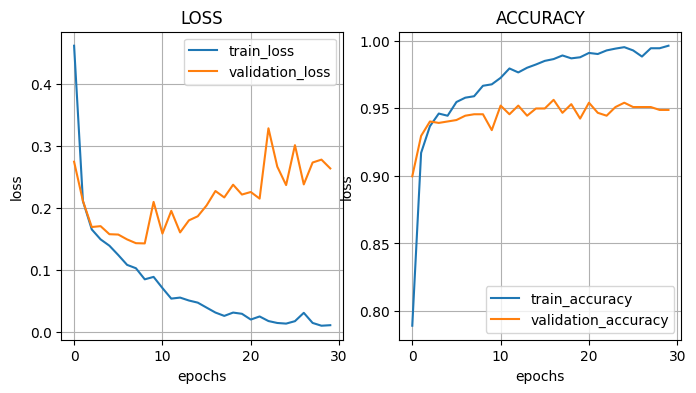

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label = "train_accuracy")
plt.plot(result.history["val_accuracy"], label = "validation_accuracy")
plt.legend(loc = "best")

### (2) C-P-C-P-C-P-C-P-F-D-D
- filter : 64, 128
- hidden 2개 (node : 128)
- dropout 0.3
- 학습률 : 0.0001

In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0001),
              metrics = "accuracy")
model.summary()

start_time = datetime.now()

result = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2)

end_time = datetime.now()
print("걸린시간 : ", end_time - start_time)
model.evaluate(X_test, y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 56, 56, 64)       

[0.13126367330551147, 0.9522184133529663]

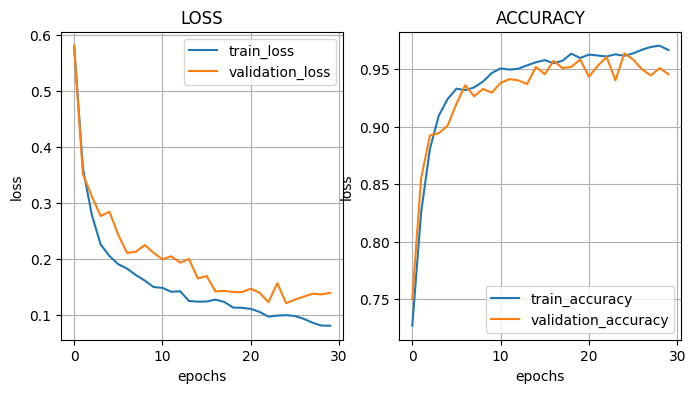

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label = "train_accuracy")
plt.plot(result.history["val_accuracy"], label = "validation_accuracy")
plt.legend(loc = "best")

### (3) C-P-C-P-C-C-F-D-D
- filter : 64, 128
- hidden 2개 (node : 128)
- dropout 0.3
- 학습률 : 0.0001

In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0001),
              metrics = "accuracy")
model.summary()

start_time = datetime.now()

result = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2)

end_time = datetime.now()
print("걸린시간 : ", end_time - start_time)
model.evaluate(X_test, y_test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_17 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 56, 56, 64)       

[0.14467564225196838, 0.9556313753128052]

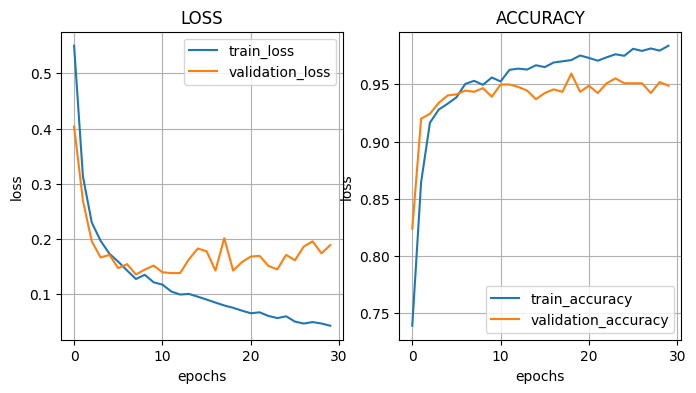

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label = "train_accuracy")
plt.plot(result.history["val_accuracy"], label = "validation_accuracy")
plt.legend(loc = "best")

### (4) C-C-P-F-D-D
- filter : 64
- hidden 2개 (node : 128)
- dropout 0.3
- 학습률 : 0.0001

In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0001),
              metrics = "accuracy")
model.summary()

start_time = datetime.now()

result = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2)

end_time = datetime.now()
print("걸린시간 : ", end_time - start_time)
model.evaluate(X_test, y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 flatten_1 (Flatten)         (None, 802816)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               102760576 
                                                      

[0.1989855170249939, 0.9505119323730469]

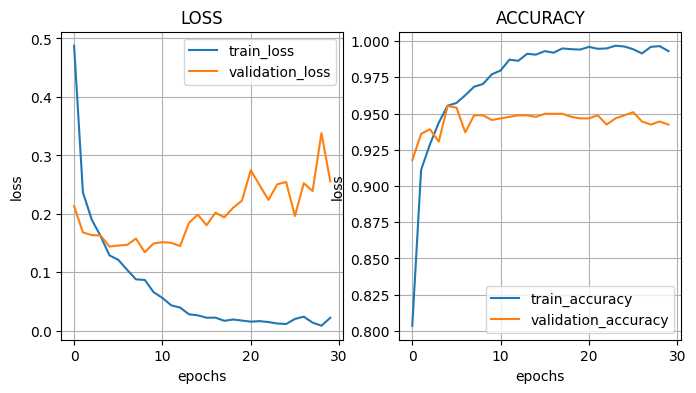

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label = "train_accuracy")
plt.plot(result.history["val_accuracy"], label = "validation_accuracy")
plt.legend(loc = "best")

### (5) C-P-C-F-D-D
- filter : 64
- hidden 2개 (node : 128)
- dropout 0.3
- 학습률 : 0.0001

In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0001),
              metrics = "accuracy")
model.summary()

start_time = datetime.now()

result = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2)

end_time = datetime.now()
print("걸린시간 : ", end_time - start_time)
model.evaluate(X_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 flatten (Flatten)           (None, 802816)            0         
                                                        

[0.17971719801425934, 0.9607508778572083]

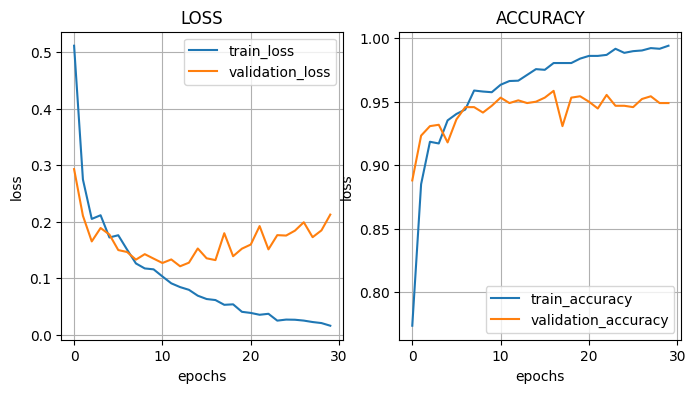

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label = "train_accuracy")
plt.plot(result.history["val_accuracy"], label = "validation_accuracy")
plt.legend(loc = "best")

# 2) 학습률 비교
    - Filter : 64, 128
    - Hidden layer : 2개 (node : 128)
    - Dropout : 0.3
    - Padding : same
    - 계층 : C - P - C - F - D - D

### (1) learning_rate = 0.001

In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = Adam(0.001),
              metrics = "accuracy")
model.summary()

start_time = datetime.now()

result = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2)

end_time = datetime.now()
print("걸린시간 : ", end_time - start_time)
model.evaluate(X_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 flatten (Flatten)           (None, 802816)            0         
                                                        

[0.46881961822509766, 0.9436860084533691]

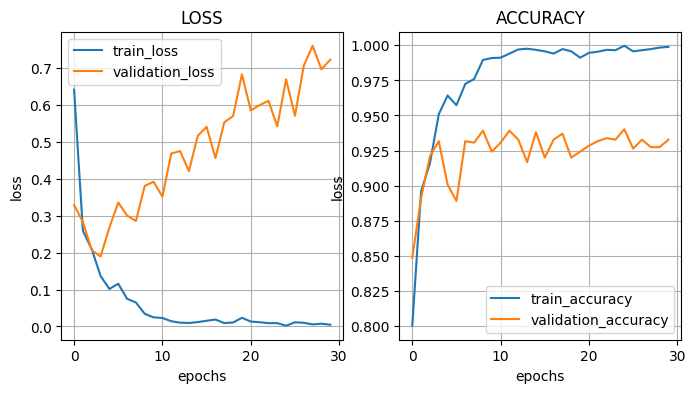

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label = "train_accuracy")
plt.plot(result.history["val_accuracy"], label = "validation_accuracy")
plt.legend(loc = "best")

### (2) learning_rate = 1e-5

In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = Adam(1e-5),
              metrics = "accuracy")
model.summary()

start_time = datetime.now()

result = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2)

end_time = datetime.now()
print("걸린시간 : ", end_time - start_time)
model.evaluate(X_test, y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 dropout_5 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 flatten_1 (Flatten)         (None, 802816)            0         
                                                      

[0.12162550538778305, 0.9547781348228455]

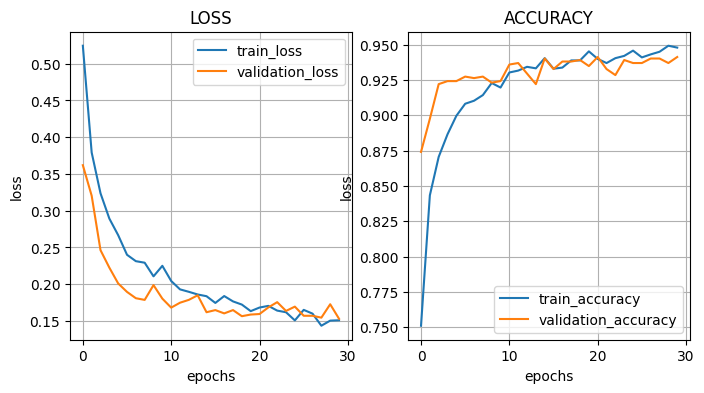

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label = "train_accuracy")
plt.plot(result.history["val_accuracy"], label = "validation_accuracy")
plt.legend(loc = "best")

### (3) learning_rate = 1e-6

In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPool2D(padding = "same"))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size = 3, padding = "same",
                 activation = "relu", input_shape = (224, 224, 3)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = Adam(1e-6),
              metrics = "accuracy")
model.summary()

start_time = datetime.now()

result = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2)

end_time = datetime.now()
print("걸린시간 : ", end_time - start_time)
model.evaluate(X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 dropout_9 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 flatten_2 (Flatten)         (None, 802816)            0         
                                                      

[0.1873207539319992, 0.9308874011039734]

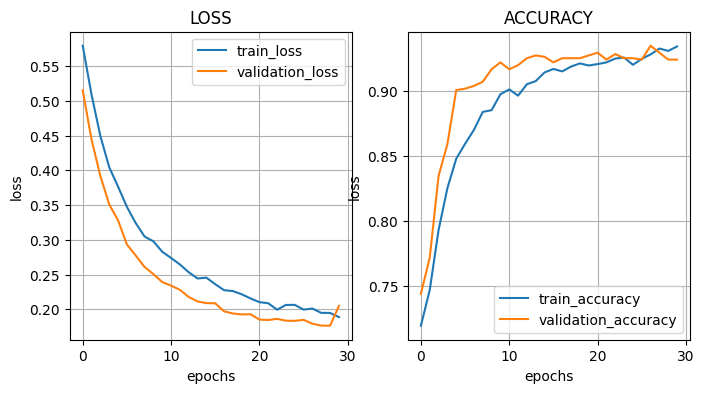

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label = "train_accuracy")
plt.plot(result.history["val_accuracy"], label = "validation_accuracy")
plt.legend(loc = "best")